In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1)

In [3]:
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MNIST = False

In [4]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/', 
    train=True, 
    transform=torchvision.transforms.ToTensor(), 
    download=DOWNLOAD_MNIST
)

train_loader = Data.DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False
)

# !!!!!!!! Change in here !!!!!!!!! #
test_x = Variable(torch.unsqueeze(test_data.data, dim=1)).type(torch.FloatTensor)[:2000].cuda() / 255.   # Tensor on GPU
test_y = test_data.targets[:2000].cuda()

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),                      
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2), 
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [6]:
cnn = CNN()

# !!!!!!!! Change in here !!!!!!!!! #
cnn.cuda()      # Moves all model parameters and buffers to the GPU.

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [7]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

losses_his = []

In [8]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):

        # !!!!!!!! Change in here !!!!!!!!! #
        b_x = Variable(x).cuda()    # Tensor on GPU
        b_y = Variable(y).cuda()    # Tensor on GPU

        output = cnn(b_x)
        
        # 计算损失
        loss = loss_func(output, b_y)
        losses_his.append(loss.item())
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 计算梯度
        loss.backward()
        
        # 优化
        optimizer.step()

        if step % 50 == 0:
            # 10列
            test_output = cnn(test_x)
            
            # !!!!!!!! Change in here !!!!!!!!! #
            # torch.max(axis=1)按行求最大值
            # 返回一对元组，第一项为最大的取值，第二项为取值所在的索引
            pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()  # move the computation in GPU

            accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.3105 | test accuracy: 0.06
Epoch:  0 | train loss: 0.6184 | test accuracy: 0.83
Epoch:  0 | train loss: 0.1289 | test accuracy: 0.87
Epoch:  0 | train loss: 0.2375 | test accuracy: 0.91
Epoch:  0 | train loss: 0.4050 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0841 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1933 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1095 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1252 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0685 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2215 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2107 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0243 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0848 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2154 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1028 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0424 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0933 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0540 | test accuracy

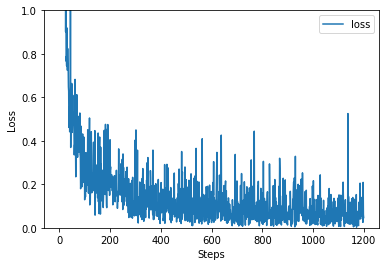

In [9]:
plt.plot(losses_his, label='loss')
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 1))
plt.show()

In [10]:
# !!!!!!!! Change in here !!!!!!!!! #
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze() # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0') prediction number
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0') real number
